In [1]:
import os
import sys
import pandas as pd
import torch
import torchaudio
import torch.nn.functional as F
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import json
import numpy as np
import math
import seaborn as sns
sns.set_theme()
sns.set_style("ticks")
sns.set_context("paper")

from typing import Optional

from datetime import timedelta

from src.utils import (
    create_dataset, plot_spectrogram,
    RandomClip, extract_logmel, pad_tensor, plot_waveform
)
from src.datasets import VoxCelebDataModule
from src.models import SEBlock, SpeakerRecognitionModel, build_efficientnetv2
from torch import nn
from sklearn.decomposition import PCA

from src.losses import SubCenterAAMSoftmaxLoss
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from pedalboard import Pedalboard, Reverb, Chorus

In [42]:
SAMPLE_WAV_SPEECH_PATH = "E:\Datasets\VoxCeleb1\\vox1_dev\id10015\\7rzuEmfRFEA\\00001.wav"
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)

In [45]:
mfcc_t = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=40
)

In [48]:
mfcc = mfcc_t(waveform)

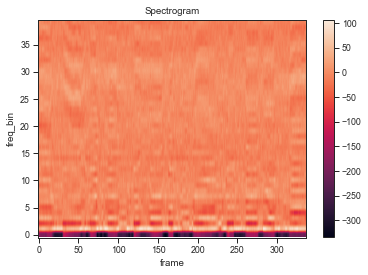

In [50]:
plot_spectrogram(mfcc[0])

In [ ]:
spr = torchaudio.transforms.Spectrogram()
sprr = spr(waveform)

In [ ]:
sprr2 = librosa.feature.melspectrogram(
    y=waveform.numpy()[0],
    sr=16000,
    power=1
)

In [ ]:
plot_spectrogram(np.log(sprr2))

In [ ]:
SAMPLE_WAV_SPEECH_PATH = "/media/gabriele/Seagate Expansion Drive/Datasets/VoxCeleb1/vox1_dev/id10001/1zcIwhmdeo4/00001.wav"
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)

In [ ]:
waveform, sample_rate

In [ ]:
waveform.shape

In [ ]:
reverb = Pedalboard(
    [Reverb(room_size=0.75)]
)

In [ ]:
board = Pedalboard([Chorus(), Reverb(room_size=0.25)])

In [ ]:
board(waveform, sample_rate=16000)

In [ ]:
reverb(waveform, sample_rate=16000)

In [ ]:
rc = RandomClip()

In [ ]:
clipped = rc(waveform)
clipped.shape

In [ ]:
n_fft = 512
mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=400,
        hop_length=160,
        center=True,
        pad_mode="reflect",
        power=2.0, # energy instead of power
        norm="slaney",
        onesided=True,
        n_mels=80,
        mel_scale="htk",
    )

In [ ]:
cmn = T.SlidingWindowCmn(cmn_window=n_fft)
to_db = T.AmplitudeToDB(stype="amplitude")

In [ ]:
logmel = mel_spectrogram(clipped)
logmel.shape

In [ ]:
logmel

In [ ]:
logmel = extract_logmel(clipped, sample_rate=16000, n_mels=80)
logmel.shape

In [ ]:
logmel = torch.load("E:\Datasets\VoxCeleb1\subset\\features_3\\train\id10075\\08H4--mL1LQ\\00001_.pt")

In [ ]:
logeml = logmel + 1e-6
logeml = torch.log(logeml)
logmel = F.instance_norm(logmel)

In [ ]:
plot_spectrogram(logmel[0])

In [ ]:
freq_masking = T.FrequencyMasking(freq_mask_param=10)
time_masking = T.TimeMasking(time_mask_param=5)

In [ ]:
spec_logmel = time_masking(freq_masking(logmel))

In [ ]:
plot_spectrogram(time_masking(freq_masking(logmel))[0])

In [ ]:
create_dataset(
    num_speakers=100, 
    to_db_flag=True,
    cmn_flag=True,
    clip_secs=3,
    n_fft=400,
    win_length=400,
    hop_length=160,
    n_mels=80,
    power=1.0,
    data_aug=True
    # base_path="/media/gabriele/Seagate Expansion Drive/Datasets/VoxCeleb1/",
    # noise_dir="/media/gabriele/Seagate Expansion Drive/Datasets/Musan/noise",
    # babble_dir="/media/gabriele/Seagate Expansion Drive/Datasets/Musan/speech"
)

In [ ]:
df = pd.read_csv("E:\Datasets\VoxCeleb1\subset\subset_labels_3.csv")
speaker_ids = df.index.tolist()

In [ ]:
create_dataset(
    num_speakers=5,
    clip_secs=6, 
    to_db_flag=True, 
    cmn_flag=True,
    speaker_ids=speaker_ids
    # base_path="/media/gabriele/Seagate Expansion Drive/Datasets/VoxCeleb1/",
    # noise_dir="/media/gabriele/Seagate Expansion Drive/Datasets/Musan/noise",
    # babble_dir="/media/gabriele/Seagate Expansion Drive/Datasets/Musan/speech"
)

In [6]:
num_secs = 3
csv_base_path: str = "E:/Datasets/VoxCeleb1/subset/"
set_name: str = "train"
df = pd.read_csv(
            csv_base_path + f"subset_features_{num_secs}.csv"
        )

In [7]:
df

,Set,Speaker,Type,Augment,Seconds,Path,File
0,train,id10004,logmel,none,3.0,id10004/bIZQaEVuATQ,features_3/train/id10004/bIZQaEVuATQ/00006_.pt
1,train,id10004,logmel,speed,3.0,id10004/bIZQaEVuATQ,features_3/train/id10004/bIZQaEVuATQ/00006_spd.pt
2,train,id10004,logmel,noise,3.0,id10004/bIZQaEVuATQ,features_3/train/id10004/bIZQaEVuATQ/00006_ns.pt
3,train,id10004,logmel,reverb,3.0,id10004/bIZQaEVuATQ,features_3/train/id10004/bIZQaEVuATQ/00006_rvr...
4,train,id10004,logmel,babble,3.0,id10004/bIZQaEVuATQ,features_3/train/id10004/bIZQaEVuATQ/00006_bbl.pt
...,...,...,...,...,...,...,...
60349,train,id11239,logmel,none,3.0,id11239/XQI8Bp9-Zcc,features_3/train/id11239/XQI8Bp9-Zcc/00004_.pt
60350,train,id11239,logmel,speed,3.0,id11239/XQI8Bp9-Zcc,features_3/train/id11239/XQI8Bp9-Zcc/00004_spd.pt
60351,train,id11239,logmel,noise,3.0,id11239/XQI8Bp9-Zcc,features_3/train/id11239/XQI8Bp9-Zcc/00004_ns.pt
60352,train,id11239,logmel,reverb,3.0,id11239/XQI8Bp9-Zcc,features_3/train/id11239/XQI8Bp9-Zcc/00004_rvr...


In [9]:
df_train = df[df["Set"] == "train"]
df_train

,Set,Speaker,Type,Augment,Seconds,Path,File
0,train,id10004,logmel,none,3.0,id10004/bIZQaEVuATQ,features_3/train/id10004/bIZQaEVuATQ/00006_.pt
1,train,id10004,logmel,speed,3.0,id10004/bIZQaEVuATQ,features_3/train/id10004/bIZQaEVuATQ/00006_spd.pt
2,train,id10004,logmel,noise,3.0,id10004/bIZQaEVuATQ,features_3/train/id10004/bIZQaEVuATQ/00006_ns.pt
3,train,id10004,logmel,reverb,3.0,id10004/bIZQaEVuATQ,features_3/train/id10004/bIZQaEVuATQ/00006_rvr...
4,train,id10004,logmel,babble,3.0,id10004/bIZQaEVuATQ,features_3/train/id10004/bIZQaEVuATQ/00006_bbl.pt
...,...,...,...,...,...,...,...
60349,train,id11239,logmel,none,3.0,id11239/XQI8Bp9-Zcc,features_3/train/id11239/XQI8Bp9-Zcc/00004_.pt
60350,train,id11239,logmel,speed,3.0,id11239/XQI8Bp9-Zcc,features_3/train/id11239/XQI8Bp9-Zcc/00004_spd.pt
60351,train,id11239,logmel,noise,3.0,id11239/XQI8Bp9-Zcc,features_3/train/id11239/XQI8Bp9-Zcc/00004_ns.pt
60352,train,id11239,logmel,reverb,3.0,id11239/XQI8Bp9-Zcc,features_3/train/id11239/XQI8Bp9-Zcc/00004_rvr...


In [ ]:
label_dict = pd.read_csv(
            csv_base_path + f"subset_labels_{num_secs}.csv"
        ).to_dict()["label"]

In [ ]:
label_dict

In [ ]:
melspecs = []
y = []
for idx, row in df.iterrows():
    melspec = torch.load(row["File"]).numpy()
    melspecs.append(
        melspec
    )
    y.append(
        label_dict[row["Speaker"]]
    )

In [ ]:
X = np.vstack(melspecs)
X.shape

In [ ]:
X = X.reshape(X.shape[0], 80*301)
X.shape

In [ ]:
y = np.vstack(y).squeeze(-1)
y.shape

In [ ]:
kmeans = KMeans(n_clusters=8)

In [ ]:
kmeans.fit(X)

In [ ]:
pca = PCA(2)

In [ ]:
Xpca = pca.fit_transform(X)

In [ ]:
u_y = np.unique(y)

In [ ]:
y

In [ ]:
Xpca[y == 0]

In [ ]:
for label in u_y:
    plt.scatter(
        Xpca[y == label, 0], 
        Xpca[y == label, 1], 
        label=label,
        alpha=0.7
    )
plt.legend()
plt.show()

In [ ]:
svc = SVC()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
svc.fit(X_train,y_train)

In [ ]:
pred = svc.predict(X_test)

In [ ]:
accuracy_score(y_test, pred)

In [ ]:
mlp = MLPClassifier()

In [ ]:
mlp.fit(X_train, y_train)

In [ ]:
pred = mlp.predict(X_test)

In [ ]:
accuracy_score(y_test, pred)

In [ ]:
optimizer = torch.optim.AdamW(
    [torch.randn((4,5))], 
    lr=1e-3, 
    eps=1e-8
)

In [ ]:
optimizer.state_dict()

In [ ]:
optimizer.state_dict()["param_groups"][0]

In [ ]:
import random
random.randint(0,4)

In [ ]:
waveform = torch.load(
    "E:\Datasets\VoxCeleb1\subset\\features_4\\train\id10206\\0dATli9-ofc\\00001_.pt"
)

In [ ]:
waveform.shape

In [ ]:
logmel = extract_logmel(waveform)

In [ ]:
logmel.shape

In [ ]:
res = pad_tensor(
    logmel, 401, 450
)

In [ ]:
res[0][1]

In [79]:
def create_mfcc(
    base_path: str = "E:/Datasets/VoxCeleb1/",
    num_secs: int = 4,
    data_aug: bool = True
):
    mfcc_t = torchaudio.transforms.MFCC(
        sample_rate=16000,
        n_mfcc=30
    )

    random_clip = RandomClip(clip_secs=num_secs)

    df = pd.read_csv(
        base_path + f"subset/subset_features_{num_secs}.csv"
    )
    df = df[df["Augment"] == "none"]
    label_dict = pd.read_csv(
        base_path + f"subset/subset_labels_{num_secs}.csv"
    ).to_dict()["label"]

    res_ls = []

    for idx, row in df.iterrows():
        path = row["Path"]
        basename = os.path.basename(
            row["File"]
        )[0:-4]
        file_path = base_path + "vox1_dev/" + \
            path + f"/{basename}.wav"
        if not os.path.exists(file_path):
            file_path = base_path + "vox1_test/" + \
                path + f"/{basename}.wav"
        waveform, sample_rate = torchaudio.load(file_path)
        waveform = random_clip(waveform)
        mfcc = mfcc_t(waveform)
        save_dir = base_path + f"subset/mfcc_{num_secs}/" + \
            path + f"/{basename}.pt"
        os.makedirs(os.path.dirname(save_dir), exist_ok=True)
        torch.save(mfcc, save_dir)

        file_dir = f"subset/mfcc_{num_secs}/" + \
            path + f"/{basename}.pt"

        res_ls.append(
            (
                row["Set"],
                row["Speaker"],
                "mfcc",
                "none",
                path,
                file_dir,
                label_dict[row["Speaker"]]
            )
        )

    df_res = pd.DataFrame(
        res_ls, 
        columns =["Set", "Speaker","Type", "Augment", "Path", "File", "Label"]
    )
    df_res.to_csv(
        base_path + f"subset/subset_mfcc_{num_secs}.csv",
        index_label=False
    )

In [80]:
create_mfcc()

D:\Users\gabri\anaconda3\envs\tf_p3.9\lib\site-packages\torchaudio\functional\functional.py:594: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [81]:

set_name: str = "train"


In [82]:
df_train = df[df["Set"] == "train"]

In [83]:
mfcc_train = []
y_train = []
for idx, row in df_train.iterrows():
    mfcc = torch.load(base_path + row["File"]).numpy()
    mfcc_train.append(
        mfcc
    )
    y_train.append(
        row["Label"]
    )
X_train = np.vstack(mfcc_train)
X_train = X_train.reshape(X_train.shape[0], -1)
y_train = np.vstack(y_train).squeeze(-1)

In [85]:
X_train = X_train.reshape(X_train.shape[0], -1)

In [87]:
X_train[0]

array([-159.39264  , -193.43333  , -220.27695  , ...,    7.1183243,
         20.481743 ,   12.484504 ], dtype=float32)